# Redes Neurais Recorrentes - LSTM

**Objetivo**: construir um modelo preditivo baseado em redes neurais recorrentes para prever o preço de ação do Google (série temporal).

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# ignorar os warnings
warnings.filterwarnings('ignore')

In [ ]:
# conectar colab no google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# definindo algumas constantes
DATA_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/DeepLearningTensorflow/data'
TRAIN_FILE = os.path.join(DATA_PATH, 'Google_Stock_Price_Train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'Google_Stock_Price_Test.csv')

In [ ]:
# carregando os dados
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)

In [ ]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
train.shape

(1258, 6)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [ ]:
test.shape

(20, 6)

In [ ]:
# eliminar colunas com problemas de leituras
train.drop(columns=['Close', 'Volume'], inplace=True)
test.drop(columns=['Close', 'Volume'], inplace=True)

<Axes: >

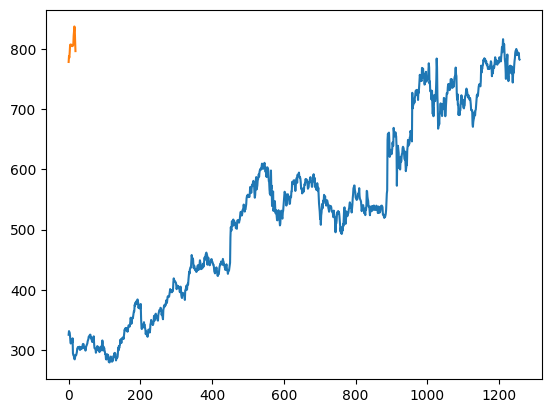

In [ ]:
train['Open'].plot()
test['Open'].plot()

### Processamento dos dados

In [ ]:
# separar treino e validação
frac = 0.3
N_TEST = int(frac * train.shape[0])

df_train = train.iloc[:-N_TEST, :]
df_val = train.iloc[-N_TEST:, :]

In [ ]:
# visualização dos conjuntos
display(df_train.tail())

display(df_val.head())

,Date,Open,High,Low
876,6/29/2015,525.01,528.61,520.54
877,6/30/2015,526.02,526.25,520.50
878,7/1/2015,524.73,525.69,518.23
879,7/2/2015,521.08,524.65,521.08
880,7/6/2015,519.50,525.25,519.00


,Date,Open,High,Low
881,7/7/2015,523.13,526.18,515.18
882,7/8/2015,521.05,522.73,516.11
883,7/9/2015,523.12,523.77,520.35
884,7/10/2015,526.29,532.56,525.55
885,7/13/2015,532.88,547.11,532.40


In [ ]:
# realizar a normalização dos conjuntos de dados
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# eliminando a coluna de data
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
test.drop(columns=['Date'], inplace=True)

In [ ]:
# treinando o scaler no treino
scaler.fit(df_train)

# transformando variáveis
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val), columns=df_val.columns)
df_test = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [ ]:
# função para transformar séries temporais em aprendizado supervisionado
def series_to_supervised(data, PAST_STEPS, FUTURE_STEPS):

  # definir listas vazias para armazenar resultados
  x, y = [], []

  # iterar pelo dataset e amostrar pontos
  for i in range(PAST_STEPS, data.shape[0] - FUTURE_STEPS):
    x.append(data[i-PAST_STEPS:i, :])
    y.append(data[i+FUTURE_STEPS-1, 0])

  # transformar para array
  x, y = np.array(x), np.array(y)

  # reformatar o x para entrar na rede neural
  x = np.reshape(x, (x.shape[0], x.shape[1], data.shape[1]))

  return x, y

In [ ]:
df_train.head()

,Open,High,Low
0,0.138950,0.155980,0.144785
1,0.157083,0.159122,0.157247
2,0.152746,0.149695,0.150606
3,0.148257,0.143712,0.140873
4,0.129281,0.124131,0.097756


In [ ]:
# queremos usar a última semana comercial (5 dias) para prever o
# preço de abertura no dia seguinte
x_train, y_train = series_to_supervised(df_train.values, PAST_STEPS=5, FUTURE_STEPS=1)
x_val, y_val = series_to_supervised(df_val.values, PAST_STEPS=5, FUTURE_STEPS=1)
x_test, y_test = series_to_supervised(df_test.values, PAST_STEPS=5, FUTURE_STEPS=1)

## Construção da classe LSTM

In [ ]:
# classe para o LSTM
class LSTM_RNN:

  def __init__(self, neuron_list: list) -> None:

    # armazenar a quantidade de unidades LSTM
    self.neuron_list = neuron_list

    # inicializar o modelo
    self.rnn_model = Sequential()

  def build_model(self,
                  x: np.array,
                  p: float=0.2,
                  show_model: bool=True) -> None:

    # adicionando camadas LSTM
    self.add_LSTM(x, p)

    # adicionando a última camada de previsão
    self.rnn_model.add(Dense(units=1, activation='relu'))

    if show_model:
      print(self.rnn_model.summary())

  def add_LSTM(self,
                x: np.array,
                p: float=0.2) -> None:

    for n in self.neuron_list:
      if n == self.neuron_list[0]:
        self.rnn_model.add(
            LSTM(
                units=n,
                return_sequences=True,
                input_shape=(x.shape[1], x.shape[2])
            )
        )
      elif n == self.neuron_list[-1]:
        self.rnn_model.add(
            LSTM(units=n)
        )
      else:
        self.rnn_model.add(
            LSTM(
                units=n,
                return_sequences=True
            )
        )
      # adicionando camadas de regularização para
      # evitar o overfitting
      self.rnn_model.add(Dropout(rate=p))

  def fit_model(self,
                train_list: list,
                val_list: list,
                N_EPOCHS: int,
                BATCH_SIZE: int,
                ) -> None:

    # salvando atributos
    self.EPOCHS = N_EPOCHS
    self.BATCH_SIZE = BATCH_SIZE

    # compilar o modelo
    self.rnn_model.compile(optimizer='adam', loss='mean_squared_error')

    # treinar o modelo
    self.history = self.rnn_model.fit(
        x=train_list[0],
        y=train_list[1],
        epochs=self.EPOCHS,
        batch_size=self.BATCH_SIZE,
        validation_data=(val_list[0], val_list[1])
    )

  def plot_history(self):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(range(1, self.EPOCHS+1), self.history.history['loss'], label='Treinamento')
    plt.plot(range(1, self.EPOCHS+1), self.history.history['val_loss'], label='Teste')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Função de Perda')
    plt.title('Curva de Aprendizado - Função de Perda')
    plt.show()

In [ ]:
# testando a classe
EPOCHS=100
BATCH_SIZE=32
rnn = LSTM_RNN(neuron_list=[200, 100, 50, 25])
rnn.build_model(x=x_train)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 200)            163200    
                                                                 
 dropout_16 (Dropout)        (None, 5, 200)            0         
                                                                 
 lstm_19 (LSTM)              (None, 5, 100)            120400    
                                                                 
 dropout_17 (Dropout)        (None, 5, 100)            0         
                                                                 
 lstm_20 (LSTM)              (None, 5, 50)             30200     
                                                                 
 dropout_18 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_21 (LSTM)              (None, 25)               

In [ ]:
# ajustar o modelo
rnn.fit_model(
    train_list=[x_train, y_train],
    val_list=[x_val, y_val],
    N_EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE
)

Epoch 1/100
28/28 [==============================] - 11s 94ms/step - loss: 0.1005 - val_loss: 0.1442
Epoch 2/100
28/28 [==============================] - 1s 45ms/step - loss: 0.0131 - val_loss: 0.0445
Epoch 3/100
28/28 [==============================] - 2s 65ms/step - loss: 0.0085 - val_loss: 0.0386
Epoch 4/100
28/28 [==============================] - 2s 66ms/step - loss: 0.0077 - val_loss: 0.0636
Epoch 5/100
28/28 [==============================] - 1s 50ms/step - loss: 0.0082 - val_loss: 0.0464
Epoch 6/100
28/28 [==============================] - 1s 34ms/step - loss: 0.0069 - val_loss: 0.0489
Epoch 7/100
28/28 [==============================] - 1s 35ms/step - loss: 0.0064 - val_loss: 0.0370
Epoch 8/100
28/28 [==============================] - 1s 35ms/step - loss: 0.0059 - val_loss: 0.0334
Epoch 9/100
28/28 [==============================] - 1s 33ms/step - loss: 0.0063 - val_loss: 0.0458
Epoch 10/100
28/28 [==============================] - 1s 33ms/step - loss: 0.0055 - val_loss: 0.030

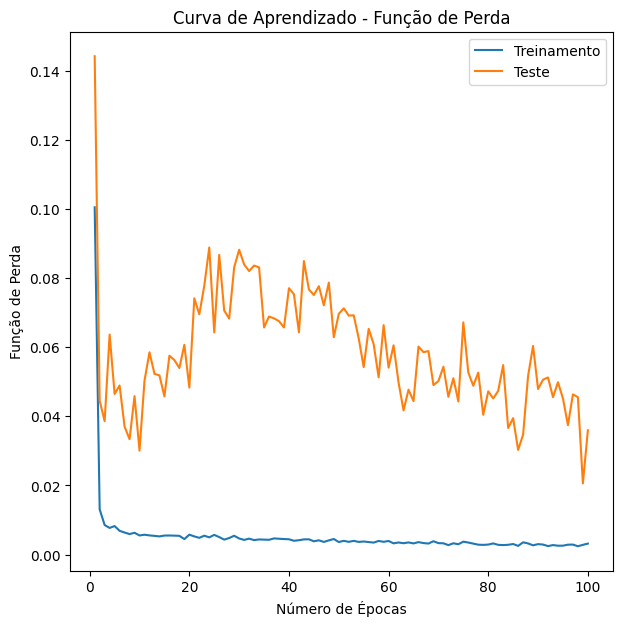

In [ ]:
# verificar a curva de aprendizado
rnn.plot_history()

In [ ]:
# realizando previsões do teste
yhat_test = rnn.rnn_model.predict(x_test)
yhat_test

1/1 [==============================] - 2s 2s/step


array([[1.2596215],
       [1.2644978],
       [1.2683132],
       [1.2712655],
       [1.2724344],
       [1.2723913],
       [1.2721329],
       [1.2720838],
       [1.2722288],
       [1.2719896],
       [1.2738373],
       [1.277292 ],
       [1.2815855],
       [1.286252 ]], dtype=float32)

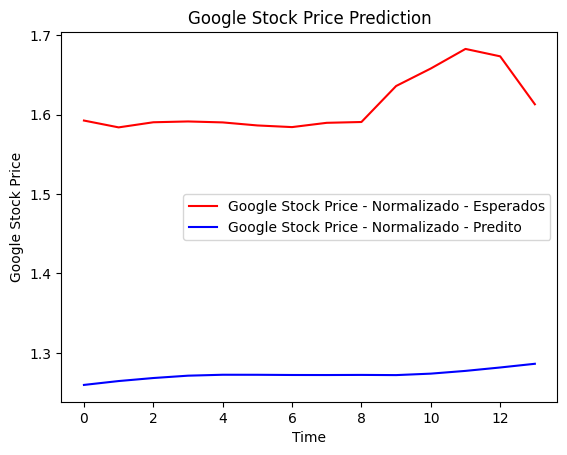

In [ ]:
# visualização final das previsões
plt.plot(y_test, color = 'red', label = 'Google Stock Price - Normalizado - Esperados')
plt.plot(yhat_test, color = 'blue', label = 'Google Stock Price - Normalizado - Predito')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()